## Understanding the Problem Statement

A startup has hired you to build a machine translation model for its new multilingual messaging app. Right now the challenge is to build an __Spanish to English__ machine translation model for the app.

## Import libraries

In [44]:
import pandas as pd
import numpy as np
import re
import warnings
import unidecode
from keras.preprocessing.sequence import pad_sequences # for padding
from keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint # to prevent overfitting and save the best model

import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

## Dataset: Spanish to English Sentences

The dataset can be downloaded from here : http://www.manythings.org/anki/spa-eng.zip

You can find several other similar datasets for different languages at http://www.manythings.org/anki/


In [45]:
# function to read the text file
def read_text(filename):
        # open the file
        file = open(filename, mode='rt', encoding='utf-8')
        # read all text
        text = file.read()
        file.close()
        return text

In [46]:
# split a text into sentences
def to_lines(text):
      sents = text.strip().split('\n')
      sents = [i.split('\t') for i in sents]
      return sents

In [47]:
# read the data
txt = read_text("spa.txt")

# convert text into list of 
sp_eng = to_lines(txt)

In [1]:
# sp_eng

In [49]:
# check count of sentence pairs in the data
len(sp_eng)

123012

In [50]:
# convert into array
sp_eng = np.array(sp_eng)

# empty lists
eng_l = []
sp_l = []

# populate the lists with sentence lengths
for i in sp_eng[:,0]:
      eng_l.append(i)

for i in sp_eng[:,1]:
      sp_l.append(i)
        
data = pd.DataFrame({'spa':sp_l, 'eng':eng_l})

In [51]:
data.tail()

,spa,eng
123007,"Hay madres y padres que se quedan despiertos después de que sus hijos se hayan dormido y se preguntan cómo conseguir pagar la hipoteca o las facturas del médico, o cómo ahorrar el suficiente diner...","There are mothers and fathers who will lie awake after the children fall asleep and wonder how they'll make the mortgage, or pay their doctor's bills, or save enough for their child's college educ..."
123008,Una huella de carbono es la cantidad de contaminación de dióxido de carbono que producimos como producto de nuestras actividades. Algunas personas intentan reducir su huella de carbono porque está...,A carbon footprint is the amount of carbon dioxide pollution that we produce as a result of our activities. Some people try to reduce their carbon footprint because they are concerned about climat...
123009,"Como suele haber varias páginas web sobre cualquier tema, normalmente sólo le doy al botón de retroceso cuando entro en una página web que tiene anuncios en ventanas emergentes. Simplemente voy a ...","Since there are usually multiple websites on any given topic, I usually just click the back button when I arrive on any webpage that has pop-up advertising. I just go to the next page found by Goo..."
123010,"Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra ...","If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until t..."
123011,"Puede que sea imposible obtener un corpus completamente libre de errores debido a la naturaleza de este tipo de esfuerzo de colaboración. Sin embargo, si animamos a los miembros a contribuir frase...","It may be impossible to get a completely error-free corpus due to the nature of this kind of collaborative effort. However, if we encourage members to contribute sentences in their own languages r..."


In [53]:
#dropping duplicates from the Spanish sentences
data.drop_duplicates(subset=['spa'],inplace=True) 

<br>

## Let's Preprocess the Text

In [54]:
# function to preprocess the text
def cleaner(text):
    newString = text.lower()
    unaccented_string = unidecode.unidecode(newString)
    newString = re.sub("'",'', unaccented_string) 
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = newString.split()
    return (" ".join(tokens)).strip()

In [55]:
# preprocess english text
cleaned_eng = []
for t in data['eng']:
    cleaned_eng.append(cleaner(t)) 
    
# preprocess Spanish text
cleaned_spa = []
for t in data['spa']:
    cleaned_spa.append(cleaner(t)) 

    
data['cleaned_eng']=cleaned_eng
data['cleaned_spa']=cleaned_spa

In [56]:
data.tail()

,spa,eng,cleaned_eng,cleaned_spa
123007,"Hay madres y padres que se quedan despiertos después de que sus hijos se hayan dormido y se preguntan cómo conseguir pagar la hipoteca o las facturas del médico, o cómo ahorrar el suficiente diner...","There are mothers and fathers who will lie awake after the children fall asleep and wonder how they'll make the mortgage, or pay their doctor's bills, or save enough for their child's college educ...",there are mothers and fathers who will lie awake after the children fall asleep and wonder how theyll make the mortgage or pay their doctors bills or save enough for their childs college education,hay madres y padres que se quedan despiertos despues de que sus hijos se hayan dormido y se preguntan como conseguir pagar la hipoteca o las facturas del medico o como ahorrar el suficiente dinero...
123008,Una huella de carbono es la cantidad de contaminación de dióxido de carbono que producimos como producto de nuestras actividades. Algunas personas intentan reducir su huella de carbono porque está...,A carbon footprint is the amount of carbon dioxide pollution that we produce as a result of our activities. Some people try to reduce their carbon footprint because they are concerned about climat...,a carbon footprint is the amount of carbon dioxide pollution that we produce as a result of our activities some people try to reduce their carbon footprint because they are concerned about climate...,una huella de carbono es la cantidad de contaminacion de dioxido de carbono que producimos como producto de nuestras actividades algunas personas intentan reducir su huella de carbono porque estan...
123009,"Como suele haber varias páginas web sobre cualquier tema, normalmente sólo le doy al botón de retroceso cuando entro en una página web que tiene anuncios en ventanas emergentes. Simplemente voy a ...","Since there are usually multiple websites on any given topic, I usually just click the back button when I arrive on any webpage that has pop-up advertising. I just go to the next page found by Goo...",since there are usually multiple websites on any given topic i usually just click the back button when i arrive on any webpage that has pop up advertising i just go to the next page found by googl...,como suele haber varias paginas web sobre cualquier tema normalmente solo le doy al boton de retroceso cuando entro en una pagina web que tiene anuncios en ventanas emergentes simplemente voy a la...
123010,"Si quieres sonar como un hablante nativo, debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un músico de banjo practica el mismo fraseo una y otra ...","If you want to sound like a native speaker, you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until t...",if you want to sound like a native speaker you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until th...,si quieres sonar como un hablante nativo debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra v...
123011,"Puede que sea imposible obtener un corpus completamente libre de errores debido a la naturaleza de este tipo de esfuerzo de colaboración. Sin embargo, si animamos a los miembros a contribuir frase...","It may be impossible to get a completely error-free corpus due to the nature of this kind of collaborative effort. However, if we encourage members to contribute sentences in their own languages r...",it may be impossible to get a completely error free corpus due to the nature of this kind of collaborative effort however if we encourage members to contribute sentences in their own languages rat...,puede que sea imposible obtener un corpus completamente libre de errores debido a la naturaleza de este tipo de esfuerz

## Split Data into Training and Validation Set

In [57]:
# train-test split
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(data['cleaned_spa'],data['cleaned_eng'], test_size = 0.2, random_state=0,shuffle=True)

- Saving validation data for later use

In [58]:
# storing validation data into new variables for later use
x_val_original = x_val
y_val_original = y_val

# reset index
y_val_original.reset_index(inplace=True, drop=True)
x_val_original.reset_index(inplace=True, drop=True)

## Encode Text Sequences

Create a dictionary of word-frequency pairs for the spanish text data in the training set (*x_tr*).

In [59]:
def build_vocab(texts):
    sentences = texts.apply(lambda x: x.split()).values
    vocab = {}
    for sentence in sentences:
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

# create word-frequency pair dictionary
source_word_freq = build_vocab(x_tr)

In [1]:
# source_word_freq

Find proportion of tokens occurring less than a threshold value. 

In [61]:
# set threshold value for rare words
thresh=2

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in source_word_freq.items():
  tot_cnt=tot_cnt+1
  tot_freq=tot_freq+value
  if(value<thresh):
    cnt=cnt+1
    freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 42.45175936435868
Total Coverage of rare words: 1.6922193411412563


<br>

Build a word-index pair dictionary

In [62]:
# assign index, starting from 2
source_word_index={}
cnt=2
for key,value in source_word_freq.items():
  # add token if it is not rare  
  if(value>=thresh):
    source_word_index[key]=cnt  
    cnt=cnt+1

# assign index to "padding" and "unknown" tokens
source_word_index['<pad>']=0
source_word_index['<unk>']=1

<br>

### Create integer-sequences from the spanish sentences.

In [63]:
source_vocab=[key for key,value in source_word_index.items()]  #spanish vocabulary

# sentences to integer sequences (Spanish sentences - training data)
source_seq_tr=[]
for i in x_tr:
  seq=[]
  for j in i.split():
    if(j not in source_vocab):
      seq.append(source_word_index['<unk>'])
    elif(source_word_freq[j]<thresh):
      seq.append(source_word_index['<unk>'])
    else:
      seq.append(source_word_index[j])
  source_seq_tr.append(seq)

In [118]:
source_seq_tr[:10]

[[2, 3, 4, 5, 6, 7],
 [8, 9, 10, 11, 12, 13],
 [13, 14, 15, 13, 16, 17, 18],
 [9, 19, 20, 13, 21],
 [22, 1, 23, 24, 25, 26, 27, 4, 28, 4, 29, 30],
 [31, 26, 1, 32, 33, 34],
 [35, 36, 37, 38, 39],
 [4, 40, 41, 42, 20, 43, 38, 44],
 [45, 46, 47],
 [9, 48, 49, 50]]

In [65]:
# sentences to integer sequences (Spanish sentences - validation data)
source_seq_val=[]
for i in x_val:
  seq=[]
  for j in i.split():
    if(j not in source_vocab):
      seq.append(source_word_index['<unk>'])
    elif(source_word_freq[j]<thresh):
      seq.append(source_word_index['<unk>'])
    else:
      seq.append(source_word_index[j])
  source_seq_val.append(seq)

In [66]:
# english word-frequency dictionary
target_word_freq = build_vocab(y_tr)

In [67]:
thresh=2 # set threshold count 

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in target_word_freq.items():
  tot_cnt=tot_cnt+1
  tot_freq=tot_freq+value
  if(value<thresh):
    cnt=cnt+1
    freq=freq+value
    
print("Vocabulary of rare words:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

Vocabulary of rare words: 33.86594559160931
Total Coverage of rare words: 0.6956612484872355


<br>

Build a dictionary that assigns index to every word in the vocabulary by removing the rare words

In [68]:
target_word_index={}

cnt=4 # start assigning index from 4 
for key,value in target_word_freq.items():
  if(value>=thresh):
    target_word_index[key]=cnt  
    cnt=cnt+1

# Assign index to "padding" and "unknown" token
target_word_index['<pad>']=0
target_word_index['<unk>']=1

<br>

### Create integer-sequences from the English sentences.

In [69]:
target_vocab=[key for key,value in target_word_index.items()]  #English vocabulary

# sentences to integer sequences (Engish sentences - training data)
target_seq_tr=[]
for i in y_tr:
  seq=[]
  for j in i.split():
    if(j not in target_vocab):
      seq.append(target_word_index['<unk>'])
    elif(target_word_freq[j]<thresh):
      seq.append(target_word_index['<unk>'])
    else:
      seq.append(target_word_index[j])
  target_seq_tr.append(seq)

# sentences to integer sequences (Engish sentences - validation data)
target_seq_val=[]
for i in y_val:
  seq=[]
  for j in i.split():
    if(j not in target_vocab):
      seq.append(target_word_index['<unk>'])
    elif(target_word_freq[j]<thresh):
      seq.append(target_word_index['<unk>'])
    else:
      seq.append(target_word_index[j])
  target_seq_val.append(seq)

<br>

## Pad the Sequences

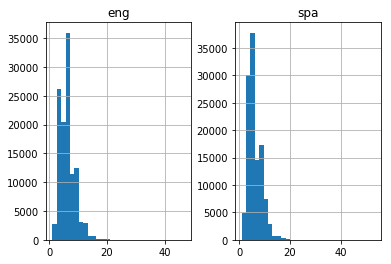

In [70]:
# check sentence length
import matplotlib.pyplot as plt

eng_word_count = []
spa_word_count = []

# populate the lists with sentence lengths
for i in data['eng']:
      eng_word_count.append(len(i.split()))

for i in data['spa']:
      spa_word_count.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_word_count, 'spa':spa_word_count})
length_df.hist(bins = 30)
plt.show()

In [71]:
# set maximum length for English and Spanish sentences
max_eng_len=15
max_spa_len=15

In [72]:
# pad Spanish sequences
x_tr = pad_sequences(source_seq_tr,  maxlen=max_spa_len, padding='post', truncating='post')
x_val = pad_sequences(source_seq_val, maxlen=max_spa_len, padding='post', truncating='post')
x_voc = len(source_vocab)

In [74]:
# pad English sequences
y_tr_pad    =   pad_sequences(target_seq_tr, maxlen=max_eng_len, padding='post', truncating="post")
y_val_pad   =   pad_sequences(target_seq_val, maxlen=max_eng_len, padding='post', truncating="post") 

In [75]:
# Add special tokens for the training data
target_word_index['<start>']=2
target_word_index['<end>']=3

# Add start token to target sequences
y_tr_start=[]
for i in y_tr_pad:
  temp=np.insert(i,0,target_word_index['<start>'])
  y_tr_start.append(temp)

#Add end token to target sequences 
y_tr=[]
for i in y_tr_start:
  if(0 in list(i)):
    temp=np.insert(i,list(i).index(0),target_word_index['<end>'])
  else:
    temp=np.insert(i,len(i),target_word_index['<end>'])
  y_tr.append(temp)
  
y_tr=np.array(y_tr)

In [76]:
y_voc = len(target_word_index)   #size of english vocabulary

In [77]:
# Add special tokens for the validation data

# Add start token to target sequences
y_val_start=[]
for i in y_val_pad:
  temp=np.insert(i,0,target_word_index['<start>'])
  y_val_start.append(temp)

# Add end token to target sequences 
y_val=[]
for i in y_val_start:
  if(0 in list(i)):
    temp=np.insert(i,list(i).index(0),target_word_index['<end>'])
  else:
    temp=np.insert(i,len(i),target_word_index['<end>'])
  y_val.append(temp)
  
y_val=np.array(y_val)

In [78]:
# update maximum length
max_eng_len=max_eng_len+2

# Training Phase

In [80]:
# number of hidden units
latent_dim = 150 

# specify length of word embeddings 
embedding_dim=200

### Define Encoder Architecture

In [81]:
encoder_inputs = Input(shape=(max_spa_len,))
enc_emb =  Embedding(x_voc, embedding_dim, trainable=True)(encoder_inputs)

encoder_lstm = LSTM(latent_dim,return_sequences=True,return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

(__encoder_outputs__: all the hidden states, __state_h__: final hidden state)

### Define Decoder Architecture

In [82]:
# Decoder Architecture, using "encoder_states" as initial state.
decoder_inputs = Input(shape=(max_eng_len-1,))
dec_emb_layer = Embedding(y_voc, embedding_dim, trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_output, decoder_state_h, decoder_state_c = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_output) # probability distribution of vocab words

### Define the Model

In [83]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 15)           0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 16)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 15, 200)      2636800     input_3[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 16, 200)      1615000     input_4[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LS

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3, min_delta=0.0001)
mc = ModelCheckpoint('best_model_v4.h5',monitor='val_loss',mode='min', save_best_only=True, verbose=1)

### Fit the Model

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:],
                  epochs=100,callbacks=[es,mc], batch_size=512, 
                  validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

In [ ]:
# load the saved model and save its weights
model = load_model('best_model_v4.h5')
model.save_weights('best_model_weights_v4.h5')

In [84]:
# model.load_weights('best_model_weights_v4.h5')

# Inference Phase

In [85]:
# swap dictionary pairs
reverse_target_word_index=dict((v, k) for k, v in target_word_index.items())
reverse_source_word_index=dict((v, k) for k, v in source_word_index.items())

In [86]:
# Encode the input sequence to get the context vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
## decoder_hidden_state_input = Input(shape=(max_spa_len,latent_dim))

# Get the embeddings of the decoder sequence
decoder_inputs_2 = Input(shape=(None,))
dec_emb2= dec_emb_layer(decoder_inputs_2) 

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Final decoder model
decoder_model = Model(
    [decoder_inputs_2] + [decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [87]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['<start>']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :]) 
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='<end>'):
            decoded_sentence= decoded_sentence+sampled_token+' '

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == '<end>'  or len(decoded_sentence.split()) >= (max_eng_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence.strip()

### Translate a few sentences

In [114]:
# take a sample from the validation data
target = y_val_original[15000:15050].tolist()
source = x_val_original[15000:15050].tolist()

In [115]:
predicted=[]
for i in x_val[15000:15050]:
    predicted.append(decode_sequence(i.reshape(1,max_spa_len)))

# add the actual and the predicted sentences to a dataframe
df=pd.DataFrame({"Source":source,"Target":target,"predicted":predicted})

In [120]:
df

,Source,Target,predicted
0,ahora es imposible salir,its impossible to go out now,it is impossible now
1,tienen dos hijos y una hija,they have two sons and one daughter,they have two sons and only a daughter
2,hablo frances,i speak french,i speak french
3,tenemos frio,were cold,we need cold
4,tom es un antiguo paracaidista,tom is a former paratrooper,tom is a <unk> old
5,oi que podria nevar,i heard it might snow,i heard that might rain
6,tom todavia no sabe la verdad,tom doesnt know the truth yet,tom doesnt know yet he is true
7,el avion se aproximaba a londres,the plane was approaching london,the plane will be flying to the club
8,su pelo era castano,his hair was brown,his hair was brown
9,me alegra que estemos juntos ahora,im glad were together now,were glad youre out of that things
